In [1]:
#Importing libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from colorama import Fore
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
import itertools
from itertools import cycle
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import os
import math

In [2]:
#importing TSLA data from 12-06-2020 to 13-08-2024 for a 1 Day interval
tsla_dataframe = yf.download(tickers = "tsla", start='2020-06-12', end='2024-08-13', interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [3]:
tsla_dataframe.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1.048000e+03
mean,224.407249,229.404746,219.049869,224.328897,224.328897,1.129378e+08
std,64.317806,65.618071,62.720372,64.095478,64.095478,5.920837e+07
min,61.186001,65.732002,60.566666,62.352001,62.352001,2.940180e+07
25%,182.935005,186.264999,178.667500,182.802502,182.802502,7.439685e+07
50%,224.556664,229.850006,218.379997,224.040001,224.040001,9.987185e+07
75%,260.692505,266.685005,256.695839,261.092506,261.092506,1.325918e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,6.663786e+08


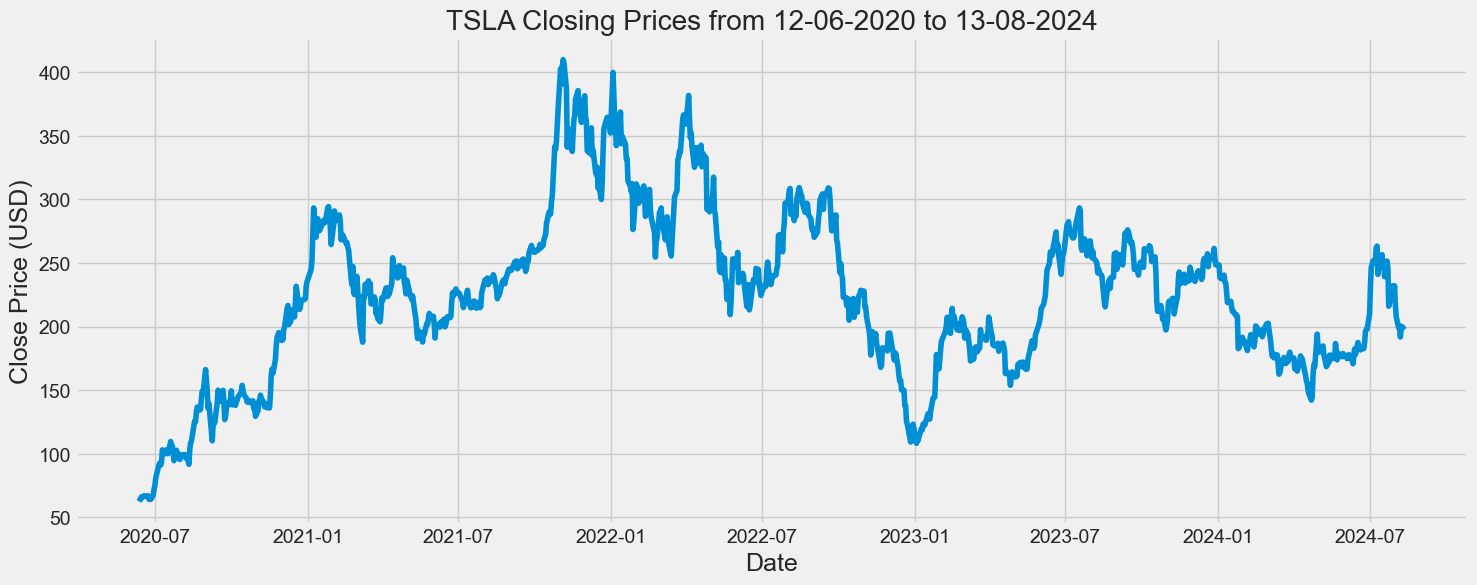

In [4]:
#plotting the closing prices
plt.figure(figsize=(16,6))
plt.title('TSLA Closing Prices from 12-06-2020 to 13-08-2024')
plt.plot(tsla_dataframe['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.show()

In [5]:
# Create closing prices dataframe 
tsla_close_df = tsla_dataframe.filter(['Close'])

In [6]:
#Scaling the closing prices data to work on a minimized range from 0 to 1
close_stock = tsla_close_df.copy()
scaled_data=MinMaxScaler(feature_range=(0,1))
tsla_close_df=scaled_data.fit_transform(np.array(tsla_close_df).reshape(-1,1))
#splitting the data as 80% for training and 20% for testing
training_set_len=int(len(tsla_close_df)*0.80)
test_set_len=len(tsla_close_df)-training_set_len
train_data,test_data=tsla_close_df[0:training_set_len,:],tsla_close_df[training_set_len:len(tsla_close_df),:1]

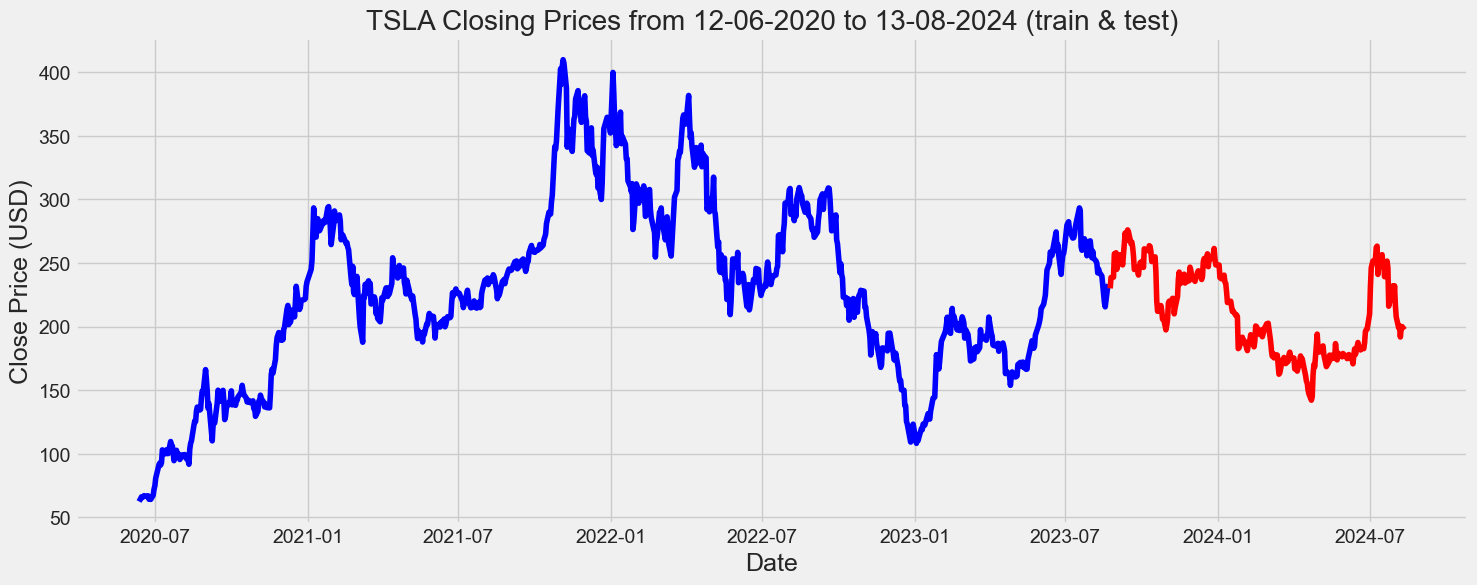

In [7]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('TSLA Closing Prices from 12-06-2020 to 13-08-2024 (train & test)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.plot(close_stock[:804], color='blue')
plt.plot(close_stock[805:], color='red')
plt.show()

In [8]:
# define a function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 15 days steps
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
#Time-Series Prediction using XGBOOST
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train, verbose=False)
#Checking the error metrics
pred = xgb_model.predict(X_test)
print("(RMSE) Root Mean squared Error: " + str(math.sqrt(mean_squared_error(y_test, pred))))
print("(MAE) Mean Absolute Error : " + str(mean_absolute_error(y_test, pred)))

(RMSE) Root Mean squared Error: 0.02467510672706225
(MAE) Mean Absolute Error : 0.01828280649901618


In [10]:
# Creating predictions dataset
train_pred=xgb_model.predict(X_train)
test_pred=xgb_model.predict(X_test)
train_pred = train_pred.reshape(-1,1)
test_pred = test_pred.reshape(-1,1)
# Inverse Transformation from scaling to closing price
og_ytrain = scaled_data.inverse_transform(y_train.reshape(-1,1)) 
og_ytest = scaled_data.inverse_transform(y_test.reshape(-1,1)) 
train_pred = scaled_data.inverse_transform(train_pred)
test_pred = scaled_data.inverse_transform(test_pred)

In [11]:
# plotting

# shift train predictions for plotting
prev=time_step
plotTrain = np.empty_like(tsla_close_df)
plotTrain[:, :] = np.nan
plotTrain[prev:len(train_pred)+prev, :] = train_pred

# shift test predictions for plotting
plotTest = np.empty_like(tsla_close_df)
plotTest[:, :] = np.nan
plotTest[len(train_pred)+(prev*2)+1:len(tsla_close_df)-1, :] = test_pred

names = cycle(['Actual closing price','Training set','Predicted closing price'])

plotdf = pd.DataFrame({'date': close_stock.index,
                       'original_close': close_stock['Close'],
                      'train_predicted_close': plotTrain.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': plotTest.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Closing price','date': 'Date'})
fig.update_layout(title_text='Actual closing price vs Predicted closing price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Closing Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [12]:
# predict the upcoming 7 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

pred_output=[]
n_steps=time_step
i=0
pred_days = 7
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        yhat = xgb_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        pred_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = xgb_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        pred_output.extend(yhat.tolist())
        
        i=i+1

In [13]:
#creating day arrays for plotting
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
#plotting 7 days prediction
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

lst_actual_days = temp_mat
nxt_pred_days = temp_mat

lst_actual_days[0:time_step+1] = scaled_data.inverse_transform(tsla_close_df[len(tsla_close_df)-time_step:]).reshape(1,-1).tolist()[0]
nxt_pred_days[time_step+1:] = scaled_data.inverse_transform(np.array(pred_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'lst_actual_days':lst_actual_days,
    'nxt_pred_days':nxt_pred_days
})

names = cycle(['Last 15 days closing price','Predicted next 7 days closing price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['lst_actual_days'],
                                                      new_pred_plot['nxt_pred_days']],
              labels={'value': 'Close pricing','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 7 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Closing Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [14]:
#plttong the full range with the prediction
xgbmodel_prices=tsla_close_df.tolist()
xgbmodel_prices.extend((np.array(pred_output).reshape(-1,1)).tolist())
xgbmodel_prices=scaled_data.inverse_transform(xgbmodel_prices).reshape(1,-1).tolist()[0]
names = cycle(['Closing Price'])
fig = px.line(xgbmodel_prices,labels={'value': 'Closing pricing','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price range with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='TSLA')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()